In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sympy.stats import *
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
from datetime import date, timedelta
import os
import time
import warnings
import requests
from bs4 import BeautifulSoup
from sympy.stats import Bernoulli, density
from sympy import S
from scipy.stats import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
from sympy.stats import *

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

In [122]:
sched = pd.read_csv(r"C:\Users\Jordan\AppData\Local\Programs\Python\Python37\schedule_nba.csv") 
pbp = pd.read_csv(r"C:\Users\Jordan\AppData\Local\Programs\Python\Python37\seasoned_data.csv") 
pbp['game_id'] = pd.to_numeric(pbp['game_id'], errors='coerce')
pbp['game_id'].fillna(0, inplace = True)
pbp['game_id'] = pbp['game_id'].astype(int)

pbp.head()

,game_id,data_set,date,a1,a2,a3,a4,a5,h1,h2,h3,h4,h5,period,away_score,home_score,remaining_time,elapsed,play_length,play_id,team,event_type,assist,away,home,block,entered,left,num,opponent,outof,player,points,possession,reason,result,steal,type,shot_distance,original_x,original_y,converted_x,converted_y,description
0,21900001,2019-2020 Regular Season,10/22/2019,Jrue Holiday,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,OG Anunoby,Pascal Siakam,Marc Gasol,Kyle Lowry,Fred VanVleet,1,0,0,0:12:00,0:00:00,0:00:00,2,NaN,start of period,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,start of period,NaN,NaN,NaN,NaN,NaN,NaN
1,21900001,2019-2020 Regular Season,10/22/2019,Jrue Holiday,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,OG Anunoby,Pascal Siakam,Marc Gasol,Kyle Lowry,Fred VanVleet,1,0,0,0:12:00,0:00:00,0:00:00,4,NOP,jump ball,NaN,Derrick Favors,Marc Gasol,NaN,NaN,NaN,NaN,NaN,NaN,Marc Gasol,NaN,Lonzo Ball,NaN,NaN,NaN,jump ball,NaN,NaN,NaN,NaN,NaN,Jump Ball Gasol vs. Favors: Tip to Ball
2,21900001,2019-2020 Regular Season,10/22/2019,Jrue Holiday,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,OG Anunoby,Pascal Siakam,Marc Gasol,Kyle Lowry,Fred VanVleet,1,0,0,0:11:48,0:00:12,0:00:12,7,NOP,miss,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lonzo Ball,0.0,NaN,NaN,missed,NaN,unknown,11.0,2.0,114.0,24.8,16.4,MISS Ball 11' Driving Floating Jump Shot
3,21900001,2019-2020 Regular Season,10/22/2019,Jrue Holiday,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,OG Anunoby,Pascal Siakam,Marc Gasol,Kyle Lowry,Fred VanVleet,1,0,0,0:11:47,0:00:13,0:00:01,8,NOP,rebound,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Derrick Favors,NaN,NaN,NaN,NaN,NaN,rebound offensive,NaN,NaN,NaN,NaN,NaN,Favors REBOUND (Off:1 Def:0)
4,21900001,2019-2020 Regular Season,10/22/2019,Jrue Holiday,Brandon Ingram,Derrick Favors,JJ Redick,Lonzo Ball,OG Anunoby,Pascal Siakam,Marc Gasol,Kyle Lowry,Fred VanVleet,1,2,0,0:11:47,0:00:13,0:00:00,9,NOP,shot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Derrick Favors,2.0,NaN,NaN,made,NaN,unknown,1.0,0.0,-6.0,25.0,4.4,Favors 1' Tip Layup Shot (2 PTS)


In [123]:
##Create Update Merged DF

merged = pd.merge(pbp, sched, on='game_id')

merged['home_lineup'] = merged['h1'] + ", " + merged['h2'] + ", " + merged['h3'] + ", " + merged['h4'] + ", " + merged['h5'] 
merged['away_lineup'] = merged['a1'] + ", " + merged['a2'] + ", " + merged['a3'] + ", " + merged['a4'] + ", " + merged['a5'] 

merged = merged.replace('00:-12:00', '0:00:00')
merged = merged.replace('00:-5:00', '0:00:00')

merged['play_start'] = pd.to_datetime(merged['elapsed'], format='%H:%M:%S') -  pd.to_timedelta(merged['play_length'])
merged['play_end'] = pd.to_datetime(merged['play_start'], format='%H:%M:%S') +  pd.to_timedelta(merged['play_length'])


period_dictionary ={1 : pd.to_datetime("00:00:00", format='%H:%M:%S'),
                    2 : pd.to_datetime("00:12:00", format='%H:%M:%S'), 
                    3 : pd.to_datetime("00:24:00", format='%H:%M:%S'),
                    4 : pd.to_datetime("00:36:00", format='%H:%M:%S')} 

merged['running'] = merged['period'].map(period_dictionary)


merged['play_start'] = merged['play_start'] +  pd.to_timedelta(merged['running'])

merged['play_end'] = merged['play_end'] + pd.to_timedelta(merged['running'])

teams = ['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']

teams_playing = [merged['home_abbrev'], merged['away_abbrev']]

merged['defense'] = np.where(merged['team']==merged['home_abbrev'], merged['away_abbrev'], merged['home_abbrev'])

merged['point_diff'] = np.where(merged['team']==merged['home_abbrev'], merged['home_score'] - merged['away_score'], merged['away_score'] - merged['home_score'])

merged['date_x'] == merged['date_x'].astype('datetime64[ns]')

merged.tail(n=20)

,game_id,data_set,date_x,a1,a2,a3,a4,a5,h1,h2,h3,h4,h5,period,away_score,home_score,remaining_time,elapsed,play_length,play_id,team,event_type,assist,away,home,block,entered,left,num,opponent,outof,player,points,possession,reason,result,steal,type,shot_distance,original_x,original_y,converted_x,converted_y,description,date_y,home_abbrev,away_abbrev,home_lineup,away_lineup,play_start,play_end,running,defense,point_diff
311408,21900653,2019-2020 Regular Season,1/21/2020,Landry Shamet,Kawhi Leonard,JaMychal Green,Montrezl Harrell,Rodney McGruder,Luka Doncic,Maxi Kleber,Boban Marjanovic,Tim Hardaway Jr.,Seth Curry,4,108,105,0:00:11,0:11:49,0:00:00,716,DAL,sub,NaN,NaN,NaN,NaN,Seth Curry,Kristaps Porzingis,NaN,NaN,NaN,Kristaps Porzingis,NaN,NaN,NaN,NaN,NaN,sub,NaN,NaN,NaN,NaN,NaN,SUB: Curry FOR Porzingis,1/21/2020,DAL,LAC,"Luka Doncic, Maxi Kleber, Boban Marjanovic, Ti...","Landry Shamet, Kawhi Leonard, JaMychal Green, ...",1830-01-01 00:47:49,1830-01-01 00:47:49,1900-01-01 00:36:00,LAC,-3
311409,21900653,2019-2020 Regular Season,1/21/2020,Landry Shamet,Kawhi Leonard,JaMychal Green,Montrezl Harrell,Rodney McGruder,Luka Doncic,Maxi Kleber,Tim Hardaway Jr.,Seth Curry,Jalen Brunson,4,108,105,0:00:11,0:11:49,0:00:00,717,DAL,sub,NaN,NaN,NaN,NaN,Jalen Brunson,Boban Marjanovic,NaN,NaN,NaN,Boban Marjanovic,NaN,NaN,NaN,NaN,NaN,sub,NaN,NaN,NaN,NaN,NaN,SUB: Brunson FOR Marjanovic,1/21/2020,DAL,LAC,"Luka Doncic, Maxi Kleber, Tim Hardaway Jr., Se...","Landry Shamet, Kawhi Leonard, JaMychal Green, ...",1830-01-01 00:47:49,1830-01-01 00:47:49,1900-01-01 00:36:00,LAC,-3
311410,21900653,2019-2020 Regular Season,1/21/2020,Landry Shamet,Kawhi Leonard,Montrezl Harrell,Rodney McGruder,Maurice Harkless,Luka Doncic,Maxi Kleber,Tim Hardaway Jr.,Seth Curry,Jalen Brunson,4,108,105,0:00:11,0:11:49,0:00:00,718,LAC,sub,NaN,NaN,NaN,NaN,Maurice Harkless,JaMychal Green,NaN,NaN,NaN,JaMychal Green,NaN,NaN,NaN,NaN,NaN,sub,NaN,NaN,NaN,NaN,NaN,SUB: Harkless FOR Green,1/21/2020,DAL,LAC,"Luka Doncic, Maxi Kleber, Tim Hardaway Jr., Se...","Landry Shamet, Kawhi Leonard, Montrezl Harrell...",1830-01-01 00:47:49,1830-01-01 00:47:49,1900-01-01 00:36:00,DAL,3
311411,21900653,2019-2020 Regular Season,1/21/2020,Landry Shamet,Kawhi Leonard,Montrezl Harrell,Rodney McGruder,Maurice Harkless,Luka Doncic,Maxi Kleber,Tim Hardaway Jr.,Seth Curry,Jalen Brunson,4,108,105,0:00:07,0:11:53,0:00:04,723,LAC,foul,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Luka Doncic,NaN,Landry Shamet,NaN,NaN,personal take foul,NaN,NaN,personal take foul,NaN,NaN,NaN,NaN,NaN,Shamet Personal Take Foul (P3.PN) (S.Corbin),1/21/2020,DAL,LAC,"Luka Doncic, Maxi Kleber, Tim Hardaway Jr., Se...","Landry Shamet, Kawhi Leonard, Montrezl Harrell...",1830-01-01 00:47:49,1830-01-01 00:47:53,1900-01-01 00:36:00,DAL,3
311412,21900653,2019-2020 Regular Season,1/21/2020,Landry Shamet,Kawhi Leonard,Montrezl Harrell,Rodney McGruder,Maurice Harkless,Luka Doncic,Maxi Kleber,Tim Hardaway Jr.,Seth Curry,Jalen Brunson,4,108,105,0:00:07,0:11:53,0:00:00,725,DAL,free throw,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,Luka Doncic,0.0,NaN,NaN,missed,NaN,Free Throw 1 of 2,NaN,NaN,NaN,NaN,NaN,MISS Doncic Free Throw 1 of 2,1/21/2020,DAL,LAC,"Luka Doncic, Maxi Kleber, Tim Hardaway Jr., Se...","Landry Shamet, Kawhi Leonard, Montrezl Harrell...",1830-01-01 00:47:53,1830-01-01 00:47:53,1900-01-01 00:36:00,LAC,-3
311413,21900653,2019-2020 Regular Season,1/21/2020,Landry Shamet,Kawhi Leonard,Montrezl Harrell,Rodney McGruder,Maurice Harkless,Luka Doncic,Maxi Kleber,Tim Hardaway Jr.,Seth Curry,Jalen Brunson,4,108,105,0:00:07,0:11:53,0:00:00,726,NaN,rebound,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,team rebound,NaN,NaN,NaN,NaN,NaN,MAVERICKS Rebound,1/21/2020,DAL,LAC,"Luka Doncic, Maxi Kleber, Tim Hardaway Jr., Se...","Landry Shamet, Kawhi Leonard, Montrezl Harrell...",1830-01-01 00:47:53,1830-01-01 00:47:53,1900-01-01 00:36:00,DAL,3
311414,21900653,2019-2020 Regular Season,1/21/2020,Landry Shamet,Kawhi Leonard,Montrezl Harrell,Rodney McGruder,Maurice Harkle

In [125]:
def calc_stats(refined_query):    
    teammates = refined_query['team_lineup'].unique()
    teammates = teammates.tolist()
    teammates = [i.split(", ") for i in teammates]
    flat_teammates = [item for sublist in teammates for item in sublist]
    flat_teammates = list(dict.fromkeys(flat_teammates)) #removed the flat_teammates print call, left variable alone

    min_log = []
    game_log = []
    point_log = []
    assist_log = []
    rebound_log = []
    block_log = []
    steal_log = []
    turnover_log = []      
    three_log = []
    fgm_log = []
    miss_log = []
    assisting_log = []
    zero_three_log = []
    four_nine_log = []
    ten_fifteen_log = []
    sixteen_twentythree_log = []
    twentyfour_twentynine_log = []
    thirty_plus_log = []
    zero_three_miss_log = []
    four_nine_miss_log = []
    ten_fifteen_miss_log = []
    sixteen_twentythree_miss_log = []
    twentyfour_twentynine_miss_log = []
    thirty_plus_miss_log = []

    for i in flat_teammates: #minutes played
        player_search = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        player_search['play_length'] = pd.to_datetime(player_search['play_length'], format='%H:%M:%S')
        secs_player = player_search['play_length'].dt.second.sum()
        min_log.append((secs_player)/60)
        

    for i in flat_teammates: #number of games played
        game_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        game_played = game_count['game_id'].nunique()
        game_log.append(game_played)
        

    for i in flat_teammates: #number of FGM
        fgm_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        fgm_count = fgm_count[fgm_count['player']==i]
        fgm_count = fgm_count[fgm_count['event_type']=='shot']
        fgm_no = len(fgm_count)
        fgm_log.append(fgm_no)
        

    for i in flat_teammates: #number of misses
        miss_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        miss_count = miss_count[miss_count['player']==i]
        miss_count = miss_count[miss_count['event_type']=='miss']
        miss_no = len(miss_count)
        miss_log.append(miss_no)
        

    for i in flat_teammates: #total points scored
        point_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        player_shots = point_count[point_count['player']==i]
        points = player_shots['points'].sum()
        point_log.append(points)
        

    for i in flat_teammates: #3 pointers scored
        three_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        three_count = three_count[three_count['player']==i]
        three_count = three_count[three_count['points']==3]
        threes = three_count['points'].sum()
        three_no = threes / 3
        three_log.append(three_no)
        

    for i in flat_teammates: #assists
        assist_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        assist_count = assist_count[assist_count['assist'].str.contains(i, na=False)==True]
        assist_no = len(assist_count)
        assist_log.append(assist_no)

        
    for i in flat_teammates: #rebounds
        rebound_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        rebound_count = rebound_count[rebound_count['player'].str.contains(i, na=False)==True]
        rebound_count = rebound_count[rebound_count['event_type']=='rebound']
        rebound_no = len(rebound_count)
        rebound_log.append(rebound_no)

        
    for i in flat_teammates: #steals
        steal_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        steal_count = steal_count[steal_count['steal'].str.contains(i, na=False)==True]
        steal_no = len(steal_count)
        steal_log.append(steal_no)

        
    for i in flat_teammates: #blocks
        block_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        block_count = block_count[block_count['block'].str.contains(i, na=False)==True]
        block_no = len(block_count)
        block_log.append(block_no)
        

    for i in flat_teammates: #turnovers
        turnover_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        turnover_count = turnover_count[turnover_count['player'].str.contains(i, na=False)==True]
        turnover_count = turnover_count[turnover_count['event_type']=='turnover']
        turnover_no = len(turnover_count)
        turnover_log.append(turnover_no)

        
    for i in flat_teammates: #unassisted fg
        assisting_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        assisting_count = assisting_count[assisting_count['player']==i]
        assisting_count = assisting_count[assisting_count['event_type']=='shot']
        assisting_no = assisting_count['assist'].isnull().sum()
        assisting_log.append(assisting_no)    
        
        
    for i in flat_teammates: #0-3
        zero_three_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        zero_three_count = zero_three_count[zero_three_count['player']==i]
        zero_three_count = zero_three_count[zero_three_count['event_type']=='shot']
        zero_three_count = zero_three_count[(zero_three_count['shot_distance'] >= 0) & (zero_three_count['shot_distance'] <=3)]
        zero_three_no = len(zero_three_count)
        zero_three_log.append(zero_three_no)
        
        
    for i in flat_teammates: #4-9
        four_nine_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        four_nine_count = four_nine_count[four_nine_count['player']==i]
        four_nine_count = four_nine_count[four_nine_count['event_type']=='shot']
        four_nine_count = four_nine_count[(four_nine_count['shot_distance'] >= 4) & (four_nine_count['shot_distance'] <=9)]
        four_nine_no = len(four_nine_count)
        four_nine_log.append(four_nine_no)    

        
    for i in flat_teammates: #10-15
        ten_fifteen_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        ten_fifteen_count = ten_fifteen_count[ten_fifteen_count['player']==i]
        ten_fifteen_count = ten_fifteen_count[ten_fifteen_count['event_type']=='shot']
        ten_fifteen_count = ten_fifteen_count[(ten_fifteen_count['shot_distance'] >= 10) & (ten_fifteen_count['shot_distance'] <= 15)]
        ten_fifteen_no = len(ten_fifteen_count)
        ten_fifteen_log.append(ten_fifteen_no)   
        
        
    for i in flat_teammates: #16-23
        sixteen_twentythree_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        sixteen_twentythree_count = sixteen_twentythree_count[sixteen_twentythree_count['player']==i]
        sixteen_twentythree_count = sixteen_twentythree_count[sixteen_twentythree_count['event_type']=='shot']
        sixteen_twentythree_count = sixteen_twentythree_count[(sixteen_twentythree_count['shot_distance'] >= 16) & (sixteen_twentythree_count['shot_distance'] <= 23)]
        sixteen_twentythree_no = len(sixteen_twentythree_count)
        sixteen_twentythree_log.append(sixteen_twentythree_no)     
        
        
    for i in flat_teammates: #24-29
        twentyfour_twentynine_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        twentyfour_twentynine_count = twentyfour_twentynine_count[twentyfour_twentynine_count['player']==i]
        twentyfour_twentynine_count = twentyfour_twentynine_count[twentyfour_twentynine_count['event_type']=='shot']
        twentyfour_twentynine_count = twentyfour_twentynine_count[(twentyfour_twentynine_count['shot_distance'] >= 24) & (twentyfour_twentynine_count['shot_distance'] <= 29)]
        twentyfour_twentynine_no = len(twentyfour_twentynine_count)
        twentyfour_twentynine_log.append(twentyfour_twentynine_no)  

        
    for i in flat_teammates: #30+
        thirty_plus_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        thirty_plus_count = thirty_plus_count[thirty_plus_count['player']==i]
        thirty_plus_count = thirty_plus_count[thirty_plus_count['event_type']=='shot']
        thirty_plus_count = thirty_plus_count[(thirty_plus_count['shot_distance'] >= 30)]
        thirty_plus_no = len(thirty_plus_count)
        thirty_plus_log.append(thirty_plus_no)  
        

    for i in flat_teammates: #0-3 miss
        zero_three_miss_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        zero_three_miss_count = zero_three_miss_count[zero_three_miss_count['player']==i]
        zero_three_miss_count = zero_three_miss_count[zero_three_miss_count['event_type']=='miss']
        zero_three_miss_count = zero_three_miss_count[(zero_three_miss_count['shot_distance'] >= 0) & (zero_three_miss_count['shot_distance'] <=3)]
        zero_three_miss_no = len(zero_three_miss_count)
        zero_three_miss_log.append(zero_three_miss_no)
        
        
    for i in flat_teammates: #4-9 miss
        four_nine_miss_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        four_nine_miss_count = four_nine_miss_count[four_nine_miss_count['player']==i]
        four_nine_miss_count = four_nine_miss_count[four_nine_miss_count['event_type']=='miss']
        four_nine_miss_count = four_nine_miss_count[(four_nine_miss_count['shot_distance'] >= 4) & (four_nine_miss_count['shot_distance'] <=9)]
        four_nine_miss_no = len(four_nine_miss_count)
        four_nine_miss_log.append(four_nine_miss_no)    

        
    for i in flat_teammates: #10-15 miss
        ten_fifteen_miss_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        ten_fifteen_miss_count = ten_fifteen_miss_count[ten_fifteen_miss_count['player']==i]
        ten_fifteen_miss_count = ten_fifteen_miss_count[ten_fifteen_miss_count['event_type']=='miss']
        ten_fifteen_miss_count = ten_fifteen_miss_count[(ten_fifteen_miss_count['shot_distance'] >= 10) & (ten_fifteen_miss_count['shot_distance'] <= 15)]
        ten_fifteen_miss_no = len(ten_fifteen_miss_count)
        ten_fifteen_miss_log.append(ten_fifteen_miss_no)   
        
        
    for i in flat_teammates: #16-23 miss
        sixteen_twentythree_miss_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        sixteen_twentythree_miss_count = sixteen_twentythree_miss_count[sixteen_twentythree_miss_count['player']==i]
        sixteen_twentythree_miss_count = sixteen_twentythree_miss_count[sixteen_twentythree_miss_count['event_type']=='miss']
        sixteen_twentythree_miss_count = sixteen_twentythree_miss_count[(sixteen_twentythree_miss_count['shot_distance'] >= 16) & (sixteen_twentythree_miss_count['shot_distance'] <= 23)]
        sixteen_twentythree_miss_no = len(sixteen_twentythree_miss_count)
        sixteen_twentythree_miss_log.append(sixteen_twentythree_miss_no)     
        
        
    for i in flat_teammates: #24-29 miss
        twentyfour_twentynine_miss_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        twentyfour_twentynine_miss_count = twentyfour_twentynine_miss_count[twentyfour_twentynine_miss_count['player']==i]
        twentyfour_twentynine_miss_count = twentyfour_twentynine_miss_count[twentyfour_twentynine_miss_count['event_type']=='miss']
        twentyfour_twentynine_miss_count = twentyfour_twentynine_miss_count[(twentyfour_twentynine_miss_count['shot_distance'] >= 24) & (twentyfour_twentynine_miss_count['shot_distance'] <= 29)]
        twentyfour_twentynine_miss_no = len(twentyfour_twentynine_miss_count)
        twentyfour_twentynine_miss_log.append(twentyfour_twentynine_miss_no)  

        
    for i in flat_teammates: #30+ _miss
        thirty_plus_miss_count = refined_query[refined_query['team_lineup'].str.contains(i, na=False)==True]
        thirty_plus_miss_count = thirty_plus_miss_count[thirty_plus_miss_count['player']==i]
        thirty_plus_miss_count = thirty_plus_miss_count[thirty_plus_miss_count['event_type']=='miss']
        thirty_plus_miss_count = thirty_plus_miss_count[(thirty_plus_miss_count['shot_distance'] >= 30)]
        thirty_plus_miss_no = len(thirty_plus_miss_count)
        thirty_plus_miss_log.append(thirty_plus_miss_no)          
        
    wowy_log = pd.DataFrame(list(map(list, zip(flat_teammates, game_log, fgm_log, miss_log, min_log, point_log, three_log, assist_log, rebound_log, block_log, steal_log, turnover_log, assisting_log, zero_three_log, zero_three_miss_log, four_nine_log, four_nine_miss_log, ten_fifteen_log, ten_fifteen_miss_log, sixteen_twentythree_log, sixteen_twentythree_miss_log, twentyfour_twentynine_log, twentyfour_twentynine_miss_log, thirty_plus_log, thirty_plus_miss_log))))
    wowy_log.columns = ['Player', 'GP', 'FGM', 'MISS', 'MIN', 'PTS', 
                        'TPM', 'AST', 'REB', 'BLK', 'STL', 'TOV', 
                        'UA', '0-3 Made', '0-3 Miss', '4-9 Made', 
                        '4-9 Miss', '10-15 Made', '10-15 Miss', 
                        '16-23 Made', '16-23 Miss', '24-29 Made', 
                        '24-29 Miss', '30+ Made', '30+ Miss']
    
    wowy_log['MPG'] = wowy_log['MIN'] / wowy_log['GP']
    wowy_log['MIN'] = wowy_log['MIN'].round(2)
    wowy_log['MPG'] = wowy_log['MPG'].round(2)
    wowy_log['FGA'] = wowy_log['FGM'] + wowy_log['MISS']
    wowy_log['FG%'] = wowy_log['FGM'] / wowy_log['FGA']
    wowy_log['FG%'] = wowy_log['FG%'].round(2)
    wowy_log['A'] =  wowy_log['FGM'] - wowy_log['UA']
    wowy_log['%A'] = wowy_log['A'] / wowy_log['FGM']
    wowy_log['%A'] = wowy_log['%A'].round(3)
    wowy_log['0-3 Att.'] = wowy_log['0-3 Miss'] + wowy_log['0-3 Made']
    wowy_log['0-3 FG%'] = wowy_log['0-3 Made'] / wowy_log['0-3 Att.']
    wowy_log['0-3 FG%'] = round(wowy_log['0-3 FG%'], 2)
    wowy_log['4-9 Att.'] = wowy_log['4-9 Miss'] + wowy_log['4-9 Made']
    wowy_log['4-9 FG%'] = wowy_log['4-9 Made'] / wowy_log['4-9 Att.']
    wowy_log['4-9 FG%'] = round(wowy_log['4-9 FG%'], 2)
    wowy_log['10-15 Att.'] = wowy_log['10-15 Miss'] + wowy_log['10-15 Made']
    wowy_log['10-15 FG%'] = wowy_log['10-15 Made'] / wowy_log['10-15 Att.']
    wowy_log['10-15 FG%'] = round(wowy_log['10-15 FG%'],2)
    wowy_log['16-23 Att.'] = wowy_log['16-23 Miss'] + wowy_log['16-23 Made']
    wowy_log['16-23 FG%'] = wowy_log['16-23 Made'] / wowy_log['16-23 Att.']
    wowy_log['16-23 FG%'] = round(wowy_log['16-23 FG%'], 2)
    wowy_log['24-29 Att.'] = wowy_log['24-29 Miss'] + wowy_log['24-29 Made']
    wowy_log['24-29 FG%'] = wowy_log['24-29 Made'] / wowy_log['24-29 Att.']
    wowy_log['24-29 FG%'] = round(wowy_log['24-29 FG%'], 2)
    wowy_log['30+ Att.'] = wowy_log['30+ Miss'] + wowy_log['30+ Made']
    wowy_log['30+ FG%'] = wowy_log['30+ Made'] / wowy_log['30+ Att.']
    wowy_log['30+ FG%'] = round(wowy_log['30+ FG%'], 2)
    wowy_log['DKFP'] = (wowy_log['PTS'] * 1) + (wowy_log['REB'] * 1.25) + (wowy_log['AST'] * 1.5) + (wowy_log['STL'] * 2) + (wowy_log['BLK'] * 2) + (wowy_log['TPM'] * .5) + (wowy_log['TOV'] * -0.5)
    wowy_log['DKFP'] = round(wowy_log['DKFP'], 2)
    wowy_log['% 0-3'] = wowy_log['0-3 Att.'] / wowy_log['FGA']
    wowy_log['% 0-3'] = round(wowy_log['% 0-3'], 2)
    wowy_log['% 4-9'] = wowy_log['4-9 Att.'] / wowy_log['FGA']
    wowy_log['% 4-9'] = round(wowy_log['% 4-9'], 2)
    wowy_log['% 10-15'] = wowy_log['10-15 Att.'] / wowy_log['FGA']
    wowy_log['% 10-15'] = round(wowy_log['% 10-15'], 2)
    wowy_log['% 16-23'] = wowy_log['16-23 Att.'] / wowy_log['FGA']
    wowy_log['% 16-23'] = round(wowy_log['% 16-23'], 2)
    wowy_log['% 24-29'] = wowy_log['24-29 Att.'] / wowy_log['FGA']
    wowy_log['% 24-29'] = round(wowy_log['% 24-29'], 2)
    wowy_log['% 30+'] = wowy_log['30+ Att.'] / wowy_log['FGA']
    wowy_log['% 30+'] = round(wowy_log['% 30+'], 2)
    
    pd.set_option('display.expand_frame_repr', False)
    
    columnsTitles = ['Player', 'GP', 'MIN', 'MPG', 'PTS', 'REB', 
                     'AST', 'BLK', 'STL', 'TOV', 'FGA', 'FGM', 
                     'FG%', 'TPM', 'DKFP', 'A', 'UA', '%A', '0-3 Att.',
                     '0-3 Made', '% 0-3', '0-3 FG%', '4-9 Att.',
                     '4-9 Made', '% 4-9', '4-9 FG%', '10-15 Att.',
                     '10-15 Made', '% 10-15', '10-15 FG%',
                     '16-23 Att.', '16-23 Made', '% 16-23',
                     '16-23 FG%', '24-29 Att.', '24-29 Made',
                     '% 24-29', '24-29 FG%', '30+ Att.',
                     '30+ Made', '% 30+', '30+ FG%']

    wowy_log = wowy_log.reindex(columns=columnsTitles)
    
    wowy_log = wowy_log.fillna(0)
    
    return wowy_log #Returned wowy_log rather than printed it
    



In [126]:
def team_stats(refined_query):    
    
    team_points = refined_query.groupby(['game_id','team'])['points'].sum()
    only_shots = refined_query[refined_query['event_type']=='shot']
    team_shots = only_shots.groupby(['game_id','team'])['event_type'].count()
    only_misses = refined_query[refined_query['event_type']=='miss']
    team_misses = only_misses.groupby(['game_id','team'])['event_type'].count()
    only_freethrow = refined_query[refined_query['event_type']=='free throw']
    team_freethrow = only_freethrow.groupby(['game_id','team'])['event_type'].count()
    only_turnover = refined_query[refined_query['event_type']=='turnover']
    team_turnover = only_turnover.groupby(['game_id','team'])['event_type'].count()
    only_foul = refined_query[refined_query['event_type']=='foul']
    team_foul = only_foul.groupby(['game_id','team'])['event_type'].count()
    only_orb = refined_query[refined_query['type']=='rebound offensive']
    team_orb = only_orb.groupby(['game_id','team'])['event_type'].count()
    only_drb = refined_query[refined_query['type']=='rebound defensive']
    team_drb = only_drb.groupby(['game_id','team'])['event_type'].count()
    only_no_assists = only_shots[only_shots['assist'].isna()==True]
    team_unassist = only_no_assists.groupby(['game_id','team'])['event_type'].count()

    team_stats = pd.concat([team_points, team_shots, team_misses, team_freethrow, team_turnover, team_foul, team_orb, team_drb, team_unassist], axis=1)
    team_stats.to_csv("team_stats.csv")
    team_stats = pd.read_csv("team_stats.csv") #This is a jerryrig lol

    team_stats.columns = ['game_id', 'Team', 'PTS', 'FGM', 'Miss', 'FTA', 'TOV', 'Foul', 'ORB', 'DRB', 'UA']
    team_stats['FGA'] = team_stats['FGM'] + team_stats['Miss']
    team_stats['FG%'] = team_stats['FGM'] / team_stats['FGA']
    team_stats['FG%'] = team_stats['FG%'].round(3)
    team_stats['A%'] = 1 - (team_stats['UA']/team_stats['FGM'])
    team_stats['A%'] = team_stats['A%'].round(3)


    team_stats['OPP_FGA'] = team_stats.groupby('game_id')['FGA'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_FTA'] = team_stats.groupby('game_id')['FTA'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_ORB'] = team_stats.groupby('game_id')['ORB'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_DRB'] = team_stats.groupby('game_id')['DRB'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_FGM'] = team_stats.groupby('game_id')['FGM'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_TOV'] = team_stats.groupby('game_id')['TOV'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_FG%'] = team_stats['OPP_FGA'] / team_stats['OPP_FGM']

    team_part = (team_stats['FGA'] + 0.4 * team_stats['FTA'] - 1.07 * (team_stats['ORB'] / (team_stats['ORB'] + team_stats['OPP_DRB'])) * (team_stats['FGA'] - team_stats['FGM']) + team_stats['TOV'])
    opp_part = (team_stats['OPP_FGA'] + 0.4 * team_stats['OPP_FTA'] - 1.07 * (team_stats['OPP_ORB'] / (team_stats['OPP_ORB'] + team_stats['DRB'])) * (team_stats['OPP_FGA'] - team_stats['OPP_FGM']) + team_stats['OPP_TOV'])


    team_stats['POSS'] = 0.5 * (team_part + opp_part)
    team_stats['POSS'] = team_stats['POSS'].round(2)
    
    
    team_stats = team_stats[team_stats['Team']==team]

    team_stats = team_stats.append(team_stats.sum(numeric_only=True), ignore_index=True) 
    
    team_stats = team_stats.tail(n=1)
    
    team_stats['Team'] = team
    
    team_stats['FG%'] = team_stats['FGM'] / team_stats['FGA']
    
    team_stats['A%'] = 1 - (team_stats['UA'] / team_stats['FGA'])
    
    team_stats['OPP_FG%'] = team_stats['OPP_FGM'] / team_stats['OPP_FGA']
    
    return team_stats

In [127]:
def opp_stats(refined_query):    
    
    team_points = refined_query.groupby(['game_id','team'])['points'].sum()
    only_shots = refined_query[refined_query['event_type']=='shot']
    team_shots = only_shots.groupby(['game_id','team'])['event_type'].count()
    only_misses = refined_query[refined_query['event_type']=='miss']
    team_misses = only_misses.groupby(['game_id','team'])['event_type'].count()
    only_freethrow = refined_query[refined_query['event_type']=='free throw']
    team_freethrow = only_freethrow.groupby(['game_id','team'])['event_type'].count()
    only_turnover = refined_query[refined_query['event_type']=='turnover']
    team_turnover = only_turnover.groupby(['game_id','team'])['event_type'].count()
    only_foul = refined_query[refined_query['event_type']=='foul']
    team_foul = only_foul.groupby(['game_id','team'])['event_type'].count()
    only_orb = refined_query[refined_query['type']=='rebound offensive']
    team_orb = only_orb.groupby(['game_id','team'])['event_type'].count()
    only_drb = refined_query[refined_query['type']=='rebound defensive']
    team_drb = only_drb.groupby(['game_id','team'])['event_type'].count()
    only_no_assists = only_shots[only_shots['assist'].isna()==True]
    team_unassist = only_no_assists.groupby(['game_id','team'])['event_type'].count()

    team_stats = pd.concat([team_points, team_shots, team_misses, team_freethrow, team_turnover, team_foul, team_orb, team_drb, team_unassist], axis=1)
    team_stats.to_csv("team_stats.csv")
    team_stats = pd.read_csv("team_stats.csv") #This is a jerryrig lol

    team_stats.columns = ['game_id', 'Team', 'PTS', 'FGM', 'Miss', 'FTA', 'TOV', 'Foul', 'ORB', 'DRB', 'UA']
    team_stats['FGA'] = team_stats['FGM'] + team_stats['Miss']
    team_stats['FG%'] = team_stats['FGM'] / team_stats['FGA']
    team_stats['FG%'] = team_stats['FG%'].round(3)
    team_stats['A%'] = 1 - (team_stats['UA']/team_stats['FGM'])
    team_stats['A%'] = team_stats['A%'].round(3)


    team_stats['OPP_FGA'] = team_stats.groupby('game_id')['FGA'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_FTA'] = team_stats.groupby('game_id')['FTA'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_ORB'] = team_stats.groupby('game_id')['ORB'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_DRB'] = team_stats.groupby('game_id')['DRB'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_FGM'] = team_stats.groupby('game_id')['FGM'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_TOV'] = team_stats.groupby('game_id')['TOV'].apply(lambda x: x.iloc[::-1]).reset_index(drop=True)
    team_stats['OPP_FG%'] = team_stats['OPP_FGA'] / team_stats['OPP_FGM']

    team_part = (team_stats['FGA'] + 0.4 * team_stats['FTA'] - 1.07 * (team_stats['ORB'] / (team_stats['ORB'] + team_stats['OPP_DRB'])) * (team_stats['FGA'] - team_stats['FGM']) + team_stats['TOV'])
    opp_part = (team_stats['OPP_FGA'] + 0.4 * team_stats['OPP_FTA'] - 1.07 * (team_stats['OPP_ORB'] / (team_stats['OPP_ORB'] + team_stats['DRB'])) * (team_stats['OPP_FGA'] - team_stats['OPP_FGM']) + team_stats['OPP_TOV'])


    team_stats['POSS'] = 0.5 * (team_part + opp_part)
    team_stats['POSS'] = team_stats['POSS'].round(2)
    
    
    team_stats = team_stats[team_stats['Team']!=team]

    team_stats = team_stats.append(team_stats.sum(numeric_only=True), ignore_index=True) 
    
    return team_stats

In [128]:
#Scraping lineup data


#URL to scrape from

url = "https://www.cbssports.com/nba/injuries/"

#Get URL HTML
response = requests.get(url)
print(response) # Response [200] means it went through

#Parse HTML with BeautifulSoup
soup = BeautifulSoup(response.text, "html.parser")

soup.prettify()

#Read in html as pandas data frame
inactives = pd.read_html(url)

inactives = pd.concat([inactive for inactive in inactives])



new = inactives['Player'].str.split(' ', n = 5, expand = True)

inactives['first name'] = new[3]

inactives['second name'] = new[4]

inactives['full_name'] = inactives['first name'] + " " + inactives['second name']

injury_report = inactives['full_name'].tolist()

inactives.head(n=40)

<Response [200]>


,Player,Position,Updated,Injury,Injury Status,first name,second name,full_name
0,D. Hunter De'Andre Hunter,SF,"Tue, Feb 11",Ankle,Game Time Decision,De'Andre,Hunter,De'Andre Hunter
1,D. Bembry DeAndre' Bembry,SG,"Mon, Feb 10",Hand,Game Time Decision,DeAndre',Bembry,DeAndre' Bembry
2,C. Capela Clint Capela,C,"Sun, Feb 9",Heel,Expected to be out until at least Feb 20,Clint,Capela,Clint Capela
3,S. Labissiere Skal Labissiere,PF,"Sun, Feb 9",Knee,Expected to be out until at least Feb 20,Skal,Labissiere,Skal Labissiere
0,R. Williams Robert Williams,C,"Tue, Feb 11",Hip,Expected to be out until at least Feb 13,Robert,Williams,Robert Williams
0,K. Irving Kyrie Irving,PG,"Tue, Feb 11",Knee,Expected to be out until at least Feb 20,Kyrie,Irving,Kyrie Irving
1,K. Durant Kevin Durant,SF,"Thu, Oct 31",Achilles,Out for the season,Kevin,Durant,Kevin Durant
0,C. Martin Cody Martin,SF,"Tue, Feb 11",Concussion,Expected to be out until at least Feb 20,Cody,Martin,Cody Martin
0,D. Gafford Daniel Gafford,PF,"Tue, Feb 11",Ankle,Game Time Decision,Daniel,Gafford,Daniel Gafford
1,D. Valentine Denzel Valentine,SG,"Tue, Feb 11",Hamstring,Expected to be out until at least Feb 20,Denzel,Valentine,Denzel Valentine


In [129]:
#Define Filters

def filter_team(team):
    team_query = merged[(merged.loc[:,'home_abbrev']==team)|(merged.loc[:,'away_abbrev']==team)]
    team_query['team_lineup'] = np.where(team_query.loc[:,'home_abbrev']==team, team_query['home_lineup'], team_query['away_lineup'])
    team_query['team_lineup'] = np.where(team_query.loc[:,'home_abbrev']==team, team_query['home_lineup'], team_query['away_lineup'])
    
    return team_query

def filter_home_away(home_away, df):
    if len(home_away) > 0:
        if home_away == 'home':
            loc_query = df[(df['home_abbrev']==team)]
        elif home_away == 'away':
            loc_query = df[(df['away_abbrev']==team)]
        else:
            print('home_away input incorrect')
            return df
            
        return loc_query
    else:
        return df
    
def filter_date(start_date, end_date, df):
    date_query = df

    if len(start_date) > 0:
        date_query = date_query[date_query['date'] >= start_date]
    if len(end_date) > 0:
         date_query = date_query[date_query['date'] <= end_date]
            
    return date_query
        
def filter_included_players(inc_players, df):
    if len(inc_players) > 0:
        temp_df = pd.DataFrame()

        for p in inc_players:
            player_query = df[df['team_lineup'].str.contains(p)]

        temp_df = temp_df.append(player_query)
        
        return temp_df
    
    else:
        return df
    
def filter_excluded_players(exc_players, df):
    if len(exc_players) > 0:
        temp_df = pd.DataFrame()

        for i in exc_players:
            df = df[df['team_lineup'].str.contains(i, na=False)==False] #replaced player_query= with df=
            
        temp_df = temp_df.append(df) #appended df instead of player_query
            
        
        return temp_df
    
    else:
        return df
    
    
def filter_game_id(game_id, df):
    if len(game_id) > 0:
        temp_df = pd.DataFrame()
        game_query = df[(df['game_id']== int(game_id))]
        
        return game_query
    
    else:
        return df    
    
    
def run_filters(team, home_away, start_date, end_date, inc_players, exc_players):
    temp_df = filter_team(team)
    temp_df = filter_home_away(home_away, temp_df)
    temp_df = filter_date(start_date, end_date, temp_df)
    temp_df = filter_included_players(inc_players, temp_df)
    temp_df = filter_excluded_players(exc_players, temp_df)
    temp_df = pd.DataFrame(temp_df)
    
    
    return temp_df

In [130]:
#Define params and run query   

team = 'DET'
home_away = ''
start_date = ''
end_date = ''
inc_players = []
exc_players = ['Blake Griffin', 'Markieff Morris', 'Derrick Rose', 'Louis King', 'Jordan Bone', 'Luke Kennard']



#, 'Markieff Morris', 'Derrick Rose', 'Louis King', 'Jordan Bone', 'Luke Kennard'

calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))

,Player,GP,MIN,MPG,PTS,REB,AST,BLK,STL,TOV,FGA,FGM,FG%,TPM,DKFP,A,UA,%A,0-3 Att.,0-3 Made,% 0-3,0-3 FG%,4-9 Att.,4-9 Made,% 4-9,4-9 FG%,10-15 Att.,10-15 Made,% 10-15,10-15 FG%,16-23 Att.,16-23 Made,% 16-23,16-23 FG%,24-29 Att.,24-29 Made,% 24-29,24-29 FG%,30+ Att.,30+ Made,% 30+,30+ FG%
0,Tony Snell,21,134.28,6.39,36.0,6,9,3,2,1,32,15,0.47,5.0,69.00,8,7,0.533,4,3,0.12,0.75,5,4,0.16,0.80,3,2,0.09,0.67,7,1,0.22,0.14,12,4,0.38,0.33,1,1,0.03,1.0
1,Andre Drummond,22,166.62,7.57,95.0,75,17,8,12,21,80,36,0.45,1.0,244.25,19,17,0.528,52,28,0.65,0.54,20,7,0.25,0.35,3,0,0.04,0.00,1,0,0.01,0.00,3,1,0.04,0.33,1,0,0.01,0.0
2,Tim Frazier,22,112.67,5.12,32.0,16,34,2,4,19,32,14,0.44,1.0,106.00,5,9,0.357,9,8,0.28,0.89,8,2,0.25,0.25,6,2,0.19,0.33,4,2,0.12,0.50,5,0,0.16,0.00,0,0,0.00,0.0
3,Christian Wood,26,110.12,4.24,59.0,31,6,3,3,6,45,23,0.51,4.0,117.75,20,3,0.870,17,16,0.38,0.94,8,2,0.18,0.25,1,0,0.02,0.00,4,1,0.09,0.25,15,4,0.33,0.27,0,0,0.00,0.0
4,Bruce Brown,24,172.87,7.20,69.0,27,33,3,12,9,59,25,0.42,3.0,179.25,12,13,0.480,28,16,0.47,0.57,18,6,0.31,0.33,3,0,0.05,0.00,4,0,0.07,0.00,6,3,0.10,0.50,0,0,0.00,0.0
5,Langston Galloway,23,105.60,4.59,56.0,10,7,2,1,4,44,20,0.45,9.0,87.50,15,5,0.750,5,4,0.11,0.80,4,2,0.09,0.50,5,2,0.11,0.40,12,6,0.27,0.50,18,6,0.41,0.33,0,0,0.00,0.0
6,Svi Mykhailiuk,27,192.60,7.13,77.0,13,18,1,4,9,65,24,0.37,18.0,134.75,20,4,0.833,14,5,0.22,0.36,6,0,0.09,0.00,1,0,0.02,0.00,9,4,0.14,0.44,34,14,0.52,0.41,1,1,0.02,1.0
7,Thon Maker,23,68.33,2.97,41.0,15,2,4,4,2,19,13,0.68,4.0,79.75,12,1,0.923,7,6,0.37,0.86,2,1,0.11,0.50,1,0,0.05,0.00,6,5,0.32,0.83,3,1,0.16,0.33,0,0,0.00,0.0
8,Sekou Doumbouya,16,135.08,8.44,57.0,23,3,1,2,5,50,22,0.44,4.0,95.75,18,4,0.818,18,13,0.36,0.72,13,5,0.26,0.38,2,0,0.04,0.00,4,2,0.08,0.50,13,2,0.26,0.15,0,0,0.00,0.0


In [131]:
#Define params and run query   

team = 'DET'
home_away = ''
start_date = ''
end_date = ''
inc_players = []
exc_players = []



#, 'Markieff Morris', 'Derrick Rose', 'Louis King', 'Jordan Bone', 'Luke Kennard'

team_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))

,game_id,Team,PTS,FGM,Miss,FTA,TOV,Foul,ORB,DRB,UA,FGA,FG%,A%,OPP_FGA,OPP_FTA,OPP_ORB,OPP_DRB,OPP_FGM,OPP_TOV,OPP_FG%,POSS
44,963614077.0,DET,4791.0,1762.0,2007.0,1011.0,665.0,873.0,423.0,1433.0,684.0,3769.0,0.467498,0.81852,3883.0,905.0,452.0,1451.0,1842.0,611.0,0.474375,4343.56


In [132]:
#Create a plus-minus statistic for players

def plus_minus(team, player):
    temp_df = filter_team(team)
    temp_df = temp_df[temp_df['home_lineup'].str.contains(player)]
    
    plus = 0
    minus = 0
    
    temp_df = temp_df[temp_df['points'].isna() == False]
    team_points = temp_df[temp_df['team'] == team]
    opp_points = temp_df[temp_df['team'] != team]
    
    return team_points['points'].sum() - opp_points['points'].sum()

In [133]:
plus_minus('HOU','James Harden')

175.0

In [134]:
#Create gameflow chart for game

def gameflow(team, game_id):
    temp_df = filter_team(team)
    temp_df = filter_game_id(game_id, temp_df)
    
    temp_df['play_start'] = pd.to_datetime(temp_df['play_start'])
    temp_df['play_end'] = pd.to_datetime(temp_df['play_end'])
    

    persons_set = set(name.strip() for names in temp_df['team_lineup'] for name in names.split(","))
    persons = {p: i for i, p in enumerate(sorted(persons_set))}
    print(persons)
    for person in persons:
        periods = []
        for names, start, end in zip(temp_df['team_lineup'], temp_df['play_start'], temp_df['play_end']):
            if person in set(name.strip() for name in names.split(",")):
                periods.append((start, end - start))
        plt.broken_barh(periods, (persons[person] - 0.45, 0.9),
                        facecolors=plt.cm.plasma(persons[person] / len(persons)))

    plt.yticks(range(len(persons)), persons)
    
    
    plt.axvline(x='1830-01-01 00:12:00')
    plt.axvline(x='1830-01-01 00:24:00')
    plt.axvline(x='1830-01-01 00:36:00')
    
    plt.show()

{'Boban Marjanovic': 0, 'Delon Wright': 1, 'Dorian Finney-Smith': 2, 'Dwight Powell': 3, 'J.J. Barea': 4, 'Jalen Brunson': 5, 'Kristaps Porzingis': 6, 'Luka Doncic': 7, 'Maxi Kleber': 8, 'Seth Curry': 9, 'Tim Hardaway Jr.': 10}


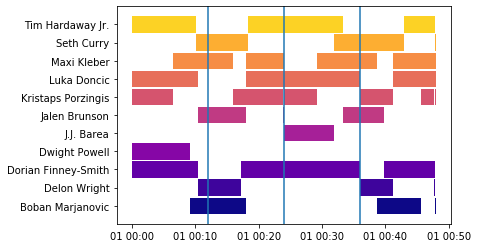

In [135]:
#Define params and run query   

team = 'DAL'
game_id = '21900653'

gameflow(team, game_id)

In [136]:
def lineup_correl(team, home_away, start_date, end_date, inc_players, exc_players, player, threshold):
    temp_df = filter_team(team)
    temp_df = filter_home_away(home_away, temp_df)
    temp_df = filter_date(start_date, end_date, temp_df)
    temp_df = filter_included_players(inc_players, temp_df)
    temp_df = filter_excluded_players(exc_players, temp_df)
    temp_df = temp_df[temp_df['team_lineup'].str.contains(player)]

    teammates = temp_df['team_lineup'].unique()
    teammates = teammates.tolist()
    teammates = [i.split(", ") for i in teammates]
    flat_teammates = [item for sublist in teammates for item in sublist]
    flat_teammates = list(dict.fromkeys(flat_teammates))
    
    minutes_logged = []
    
    for i in flat_teammates:
        temp_df['play_length'] = pd.to_datetime(temp_df['play_length'], format='%H:%M:%S')
        player_correl = temp_df[temp_df['team_lineup'].str.contains(i)]
        plays = player_correl['play_length'].dt.second.sum()
        plays = round(plays / 60,2)
        total = temp_df['play_length'].dt.second.sum()
        total = round(total / 60,2)
        minutes_logged.append(round(plays/total,2))
        
    lineup_log = list(zip(flat_teammates, minutes_logged))
    
    if threshold > 0:
        lineup_log = [i for i in lineup_log if i[1] >= threshold]
        
    else:
        lineup_log = lineup_log
    
    return lineup_log
  

In [137]:
#Define params and run query   

team = 'NOP'
home_away = ''
start_date = ''
end_date = ''
inc_players = []
exc_players = []
player = "Josh Hart"
threshold = 0.2

lineup_correl(team, home_away, start_date, end_date, inc_players, exc_players, player, threshold)

[('Jrue Holiday', 0.43),
 ('Brandon Ingram', 0.56),
 ('Derrick Favors', 0.26),
 ('JJ Redick', 0.39),
 ('Josh Hart', 1.0),
 ('Jahlil Okafor', 0.22),
 ("E'Twaun Moore", 0.3),
 ('Nickeil Alexander-Walker', 0.2),
 ('Kenrich Williams', 0.27),
 ('Nicolo Melli', 0.21),
 ('Frank Jackson', 0.2),
 ('Lonzo Ball', 0.59),
 ('Jaxson Hayes', 0.37)]

In [138]:
def get_DraftKings(url):
    file = pd.read_csv(url)
    
    return file

In [139]:
url = 'https://www.draftkings.com/lineup/getavailableplayerscsv?contestTypeId=73&draftGroupId=33445'

get_DraftKings(url)

,Position,Name + ID,Name,ID,Roster Position,Game Info,TeamAbbrev,AvgPointsPerGame
0,SF,Kawhi Leonard (14229259) (LOCKED),Kawhi Leonard,14229259,T1,Final,LAC,49.44
1,SG/SF,Bradley Beal (14229260) (LOCKED),Bradley Beal,14229260,T1,Final,WAS,46.85
2,C,Karl-Anthony Towns (14229258) (LOCKED),Karl-Anthony Towns,14229258,T1,Final,MIN,51.92
3,PG,Trae Young (14229261) (LOCKED),Trae Young,14229261,T1,Final,ATL,51.44
4,C,Joel Embiid (14229264) (LOCKED),Joel Embiid,14229264,T2,Final,PHI,47.17
5,PG/SF,Ben Simmons (14229265) (LOCKED),Ben Simmons,14229265,T2,Final,PHI,44.31
6,PF/C,Domantas Sabonis (14229262) (LOCKED),Domantas Sabonis,14229262,T2,Final,IND,44.02
7,C,Andre Drummond (14229263) (LOCKED),Andre Drummond,14229263,T2,Final,DET,48.58
8,C,Bam Adebayo (14229270) (LOCKED),Bam Adebayo,14229270,T3,Final,MIA,40.72
9,PG/SG,D'Angelo Russell (14229266) (LOCKED),D'Angelo Russell,14229266,T3,Final,GS,40.07


In [140]:
def getTeam(url):
    temp_df = pd.read_csv(url)
    
    player_list = temp_df['Name'].tolist()
    
    team_list = []
    
    
    for p in player_list:
        player_team = temp_df.loc[temp_df['Name']==p, 'TeamAbbrev'].iloc[0]
        
        team_list.append(player_team)
    
    temp_dict = dict(zip(player_list, team_list))
    
    return temp_dict
        

In [141]:
url = 'https://www.draftkings.com/lineup/getavailableplayerscsv?contestTypeId=73&draftGroupId=33437'


player_pool = getTeam(url)

print(player_pool)

{'Giannis Antetokounmpo': 'MIL', 'Devin Booker': 'PHO', 'James Harden': 'HOU', 'Russell Westbrook': 'HOU', 'Pascal Siakam': 'TOR', 'Zach LaVine': 'CHI', 'Khris Middleton': 'MIL', 'Jrue Holiday': 'NO', 'Fred VanVleet': 'TOR', 'Kyle Lowry': 'TOR', 'Deandre Ayton': 'PHO', 'Zion Williamson': 'NO', 'Brandon Ingram': 'NO', 'Serge Ibaka': 'TOR', 'Thaddeus Young': 'CHI', 'Eric Bledsoe': 'MIL', 'Kelly Oubre Jr.': 'PHO', 'Lonzo Ball': 'NO', 'Eric Gordon': 'HOU', 'OG Anunoby': 'TOR', 'Tomas Satoransky': 'CHI', 'Marc Gasol': 'TOR', 'Ricky Rubio': 'PHO', 'Ersan Ilyasova': 'MIL', 'Derrick Favors': 'NO', 'P.J. Tucker': 'HOU', 'Kris Dunn': 'CHI', 'Coby White': 'CHI', 'Luke Kornet': 'CHI', 'Mikal Bridges': 'PHO', 'Donte DiVincenzo': 'MIL', 'Brook Lopez': 'MIL', 'Danuel House Jr.': 'HOU', 'Josh Hart': 'NO'}


In [142]:
def get_games_played(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = ['Young']
        exc_players = ['Bembry', 'Reddish', 'Len']
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_games = temp_df['GP']
        
        return player_games

def get_minutes(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_mins = temp_df['MIN']
        
        return player_mins
    
def get_points(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_points = temp_df['PTS']
        
        return player_points  

def get_fga(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_fga = temp_df['FGA']
        
        return player_fga
    
def get_fgm(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_fgm = temp_df['FGM']
        
        return player_fgm  

def get_fg_per(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_fg_per = temp_df['FG%']
        
        return player_fg_per 

    
def get_mpg(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_mpg = temp_df['MPG']
        
        return player_mpg
    

def get_assists(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_assists = temp_df['AST']
        
        return player_assists
    
    
def get_tpm(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_tpm = temp_df['TPM']
        
        return player_tpm

    
def get_boards(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_boards = temp_df['REB']
        
        return player_boards
    
    
def get_blocks(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_blocks = temp_df['BLK']

        return player_blocks
    
    
def get_steals(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_steals = temp_df['STL']

        return player_steals    
    
    
def get_turnovers(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_turnovers = temp_df['TOV']

        return player_turnovers      
    
    
def get_unassisted(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_unassisted = temp_df['UA']

        return player_unassisted      
    
    
def get_assisted(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_assisted = temp_df['A']

        return player_assisted      
    

def get_assist_per(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        game_id = ''
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        player_assist_per = temp_df['%A']

        return player_assist_per    
    
def simulate_shot(team, name):
        team = team
        home_away = ""
        start_date = ''
        end_date = ''
        inc_players = []
        exc_players = []
        
        temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))
        
        temp_df = temp_df[temp_df['Player'] == name]
        
        #Percentage of FGA at distance
        
        zero_odds = temp_df.loc[temp_df['Player'] == name, '% 0-3'].values[0]
        four_odds = temp_df.loc[temp_df['Player'] == name, '% 4-9'].values[0]
        ten_odds = temp_df.loc[temp_df['Player'] == name, '% 10-15'].values[0]
        sixteen_odds = temp_df.loc[temp_df['Player'] == name, '% 16-23'].values[0]
        twentyfour_odds = temp_df.loc[temp_df['Player'] == name, '% 24-29'].values[0]
        thirty_odds = temp_df.loc[temp_df['Player'] == name, '% 30+'].values[0]
        
        #Shot Percentages
        
        zero_per = temp_df.loc[temp_df['Player'] == name, '0-3 FG%'].values[0]
        four_per = temp_df.loc[temp_df['Player'] == name, '4-9 FG%'].values[0]
        ten_per = temp_df.loc[temp_df['Player'] == name, '10-15 FG%'].values[0]
        sixteen_per = temp_df.loc[temp_df['Player'] == name, '16-23 FG%'].values[0]
        twentyfour_per = temp_df.loc[temp_df['Player'] == name, '24-29 FG%'].values[0]
        thirty_per = temp_df.loc[temp_df['Player'] == name, '30+ FG%'].values[0]
        
        
        
        shot_options = ['0-3', '4-9', '10-15', '16-23', '24-29', '30+'] 
        shot_dict = [zero_odds, four_odds, ten_odds, sixteen_odds, twentyfour_odds, thirty_odds]
        per_dict = [zero_per, four_per, ten_per, sixteen_per, twentyfour_per, thirty_per]
                     
        shot_choices = np.random.choice(shot_options, 19, shot_dict)
        
        relations = dict(zip(shot_options, per_dict))
        
        shot_odds = np.array([relations[x] for x in shot_choices]) # np.array optional
        
        shot_dictionary = []
        
        for p in shot_odds:
            trials = binom.rvs(n=100, p=p, size=20)
            trials = np.mean(trials)
            shot_dictionary.append(trials)
            
        return shot_dictionary

        

In [143]:
class Player():
    
    def __init__(self, name, team):
        self.name = name
        self.team = team
        self.games = get_games_played(team, name)
        self.minutes = get_minutes(team, name)
        self.mpg = get_mpg(team, name)
        self.points = get_points(team, name)        
        self.fga = get_fga(team, name)        
        self.fgm = get_fgm(team, name)
        self.fg_per = get_fg_per(team, name)
        self.TPM = get_tpm(team, name)
        self.AST = get_assists(team, name)
        self.REB = get_boards(team, name)
        self.BLK = get_blocks(team, name)
        self.STL = get_steals(team, name)
        self.TOV = get_turnovers(team, name)
        self.UA = get_unassisted(team, name)
        self.A = get_assisted(team, name)
        self.per_A = get_assist_per(team, name)
        self.simulate_shot = simulate_shot(team, name)


In [144]:
#kawhi_LAC = Player("Kawhi Leonard", "LAC")

#kawhi_LAC.simulate_shot

In [145]:
team = 'DET'
home_away = ""
start_date = ''
end_date = ''
inc_players = []
exc_players = ['Blake Griffin']

temp_df = calc_stats(run_filters(team, home_away, start_date, end_date, inc_players, exc_players))



In [146]:
team = 'DET'
home_away = ""
start_date = ''
end_date = ''
inc_players = []
exc_players = []
player = "Reggie Jackson"
threshold = 0.0



lineup_correl(team, home_away, start_date, end_date, inc_players, exc_players, player, threshold)

[('Tony Snell', 0.68),
 ('Markieff Morris', 0.89),
 ('Andre Drummond', 0.89),
 ('Bruce Brown', 0.71),
 ('Reggie Jackson', 1.0),
 ('Luke Kennard', 0.35),
 ('Langston Galloway', 0.37),
 ('Thon Maker', 0.11)]

In [147]:
#Return stat rankings

def league_stats(merged): 
    games = merged.groupby(['team'])['game_id'].nunique()
    team_points = merged.groupby(['team'])['points'].sum()/games
    only_shots = merged[merged['event_type']=='shot']
    team_shots = only_shots.groupby(['team'])['event_type'].count()/games
    only_misses = merged[merged['event_type']=='miss']
    team_misses = only_misses.groupby(['team'])['event_type'].count()/games
    only_freethrow = merged[merged['event_type']=='free throw']
    team_freethrow = only_freethrow.groupby(['team'])['event_type'].count()/games
    only_turnover = merged[merged['event_type']=='turnover']
    team_turnover = only_turnover.groupby(['team'])['event_type'].count()/games
    only_foul = merged[merged['event_type']=='foul']
    team_foul = only_foul.groupby(['team'])['event_type'].count()/games
    only_orb = merged[merged['type']=='rebound offensive']
    team_orb = only_orb.groupby(['team'])['event_type'].count()/games
    only_drb = merged[merged['type']=='rebound defensive']
    team_drb = only_drb.groupby(['team'])['event_type'].count()/games
    only_no_assists = only_shots[only_shots['assist'].isna()==True]
    team_unassist = only_no_assists.groupby(['team'])['event_type'].count()/games

    league_stats = pd.concat([games, team_points, team_shots, team_misses, team_freethrow, team_turnover, team_foul, team_orb, team_drb, team_unassist], axis=1)
    league_stats.to_csv("team_stats.csv")
    league_stats = pd.read_csv("team_stats.csv") #This is a jerryrig lol

    league_stats.columns = ['Team', 'GP', 'PTS', 'FGM', 'Miss', 'FTA', 'TOV', 'Foul', 'ORB', 'DRB', 'UA']
    
    rounded = ['PTS', 'FGM', 'Miss', 'FTA', 'TOV', 'Foul', 'ORB', 'DRB', 'UA']
    
    league_stats[rounded] = league_stats[rounded].round(2)
    
    league_stats['FGA'] = league_stats['FGM'] + league_stats['Miss']
    league_stats['FG%'] = league_stats['FGM'] / league_stats['FGA']
    league_stats['FG%'] = league_stats['FG%'].round(3)
    league_stats['A%'] = 1 - (league_stats['UA']/league_stats['FGM'])
    league_stats['A%'] = league_stats['A%'].round(3)

    
    
    return league_stats

In [148]:
league_stats(merged=merged)

,Team,GP,PTS,FGM,Miss,FTA,TOV,Foul,ORB,DRB,UA,FGA,FG%,A%
0,ATL,44,107.84,39.68,49.91,22.32,16.41,23.45,9.39,33.07,16.70,89.59,0.443,0.579
1,BKN,42,109.29,39.74,50.52,23.93,15.38,21.74,10.76,37.83,16.17,90.26,0.440,0.593
2,BOS,42,112.33,41.21,48.48,22.19,12.95,21.74,10.67,34.98,17.93,89.69,0.459,0.565
3,CHA,45,103.29,37.40,48.51,21.80,14.36,19.98,10.87,31.73,13.51,85.91,0.435,0.639
4,CHI,45,105.67,38.69,50.02,20.84,14.44,21.96,10.09,32.49,15.91,88.71,0.436,0.589
5,CLE,44,104.77,39.30,48.05,20.11,15.68,18.14,10.55,33.82,17.89,87.35,0.450,0.545
6,DAL,43,116.44,41.47,48.26,24.19,12.37,19.74,11.28,36.35,17.28,89.73,0.462,0.583
7,DEN,43,109.30,41.35,47.95,21.26,12.60,20.28,10.95,33.77,15.12,89.30,0.463,0.634
8,DET,44,108.89,40.05,45.61,22.98,15.11,19.84,9.61,32.57,15.55,85.66,0.468,0.612
9,GSW,45,105.64,38.33,51.09,23.33,14.13,20.38,10.62,33.58,13.64,89.42,0.429,0.644


In [149]:
def league_ranking(team, stat):
    """Returns the weighted average of a given stat for the provided team"""
    temp_df = league_stats(merged=merged)
    
    if team not in ['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 
                  'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 
                  'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']:
        return "Invalid team selection"
    else:
        if stat not in ['PTS', 'FGM', 'Miss', 'FTA', 'TOV', 'Foul', 'ORB', 'DRB', 'UA', 'FGA', 'FG%', 'A%']:
            return "Invalid stat input"
        else:
            weighted_avg = temp_df[temp_df['Team']==team][stat] / temp_df[stat].mean()
            weighted_avg = weighted_avg.iloc[0]
            weighted_avg = round(weighted_avg, 3)
            league_rank = temp_df[temp_df['Team']==team][stat].rank()
            
            print(team + ":" + "\nWeighted Average: " + str(weighted_avg) + "\nLeague Ranking: " + str(league_rank))

In [150]:
team = "HOU"
stat = "FG%"

league_ranking(team, stat)

HOU:
Weighted Average: 0.99
League Ranking: 10    1.0
Name: FG%, dtype: float64


In [151]:
def league_def_stats(merged): 
    games = merged.groupby(['defense'])['game_id'].nunique()
    team_points = merged.groupby(['defense'])['points'].sum()/games
    only_shots = merged[merged['event_type']=='shot']
    team_shots = only_shots.groupby(['defense'])['event_type'].count()/games
    only_misses = merged[merged['event_type']=='miss']
    team_misses = only_misses.groupby(['defense'])['event_type'].count()/games
    only_freethrow = merged[merged['event_type']=='free throw']
    team_freethrow = only_freethrow.groupby(['defense'])['event_type'].count()/games
    only_turnover = merged[merged['event_type']=='turnover']
    team_turnover = only_turnover.groupby(['defense'])['event_type'].count()/games
    only_foul = merged[merged['event_type']=='foul']
    team_foul = only_foul.groupby(['defense'])['event_type'].count()/games
    only_orb = merged[merged['type']=='rebound offensive']
    team_orb = only_orb.groupby(['defense'])['event_type'].count()/games
    only_drb = merged[merged['type']=='rebound defensive']
    team_drb = only_drb.groupby(['defense'])['event_type'].count()/games
    only_no_assists = only_shots[only_shots['assist'].isna()==True]
    team_unassist = only_no_assists.groupby(['defense'])['event_type'].count()/games

    league_stats = pd.concat([games, team_points, team_shots, team_misses, team_freethrow, team_turnover, team_foul, team_orb, team_drb, team_unassist], axis=1)
    league_stats.to_csv("team_stats.csv")
    league_stats = pd.read_csv("team_stats.csv") #This is a jerryrig lol

    league_stats.columns = ['Team', 'GP', 'PTS', 'FGM', 'Miss', 'FTA', 'TOV', 'Foul', 'ORB', 'DRB', 'UA']
    
    rounded = ['PTS', 'FGM', 'Miss', 'FTA', 'TOV', 'Foul', 'ORB', 'DRB', 'UA']
    
    league_stats[rounded] = league_stats[rounded].round(2)
    
    league_stats['FGA'] = league_stats['FGM'] + league_stats['Miss']
    league_stats['FG%'] = league_stats['FGM'] / league_stats['FGA']
    league_stats['FG%'] = league_stats['FG%'].round(3)
    league_stats['A%'] = 1 - (league_stats['UA']/league_stats['FGM'])
    league_stats['A%'] = league_stats['A%'].round(3)

    
    
    return league_stats

In [152]:
league_def_stats(merged=merged)


,Team,GP,PTS,FGM,Miss,FTA,TOV,Foul,ORB,DRB,UA,FGA,FG%,A%
0,ATL,44,117.50,42.75,47.59,26.86,15.64,21.30,11.52,35.84,18.05,90.34,0.473,0.578
1,BKN,42,111.62,40.93,52.57,22.83,13.43,21.57,10.93,35.93,19.12,93.50,0.438,0.533
2,BOS,42,105.67,38.57,47.88,22.93,15.48,21.12,10.05,34.07,15.43,86.45,0.446,0.600
3,CHA,45,110.47,42.09,45.73,18.20,14.69,21.44,10.71,35.24,15.07,87.82,0.479,0.642
4,CHI,45,107.80,38.69,44.51,25.56,18.18,19.96,10.18,36.33,13.84,83.20,0.465,0.642
5,CLE,44,113.89,43.77,46.09,18.50,12.89,20.23,9.95,33.50,17.95,89.86,0.487,0.590
6,DAL,43,109.37,40.81,50.07,21.65,12.42,22.23,11.14,34.07,17.47,90.88,0.449,0.572
7,DEN,43,105.60,39.07,47.05,21.65,14.44,21.05,10.05,33.35,14.53,86.12,0.454,0.628
8,DET,44,110.75,41.86,46.39,20.57,14.55,20.75,10.27,32.98,17.23,88.25,0.474,0.588
9,GSW,45,113.58,41.80,47.42,21.47,15.67,20.73,10.69,36.64,16.58,89.22,0.469,0.603


In [153]:
def league_def_ranking(team, stat):
    """Returns the weighted average of a given stat for the provided team"""
    temp_df = league_def_stats(merged=merged)
    
    if team not in ['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 
                  'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 
                  'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']:
        return "Invalid team selection"
    else:
        if stat not in ['PTS', 'FGM', 'Miss', 'FTA', 'TOV', 'Foul', 'ORB', 'DRB', 'UA', 'FGA', 'FG%', 'A%']:
            return "Invalid stat input"
        else:
            weighted_avg = temp_df[temp_df['Team']==team][stat] / temp_df[stat].mean()
            weighted_avg = weighted_avg.iloc[0]
            weighted_avg = round(weighted_avg, 3)
            league_rank = temp_df[temp_df['Team']==team][stat].rank(method='max')
            
            print(team + ":" + "\nWeighted Average: " + str(weighted_avg) + "\nLeague Ranking: " + str(league_rank))

In [154]:
team = "ORL"
stat = "FG%"

league_def_ranking(team, stat)

ORL:
Weighted Average: 0.986
League Ranking: 21    1.0
Name: FG%, dtype: float64


In [162]:
def first_sub(team):
    
    temp_df = merged[(merged.loc[:,'home_abbrev']==team)|(merged.loc[:,'away_abbrev']==team)]
    
    temp_df = temp_df[temp_df['team']==team]
    
    games = temp_df['game_id'].unique()
    
    subs = []
    point_diff = []
    
    for i in games:
        temp_game = temp_df[temp_df['game_id']==i]
        first_sub = temp_game[temp_game['event_type']=='sub'].first_valid_index()
        first_subs = temp_game['elapsed'].loc[first_sub]
        point_subs = temp_game['point_diff'].loc[first_sub]
        subs.append(first_subs)
        point_diff.append(point_subs)
    
    
    """subs = pd.to_datetime(subs, format='%H:%M:%S').strftime('%H:%M:%S')
    
    subs = pd.to_datetime(subs)"""
    
    dataframe = pd.DataFrame(list(zip(subs, point_diff)), columns = ['time', 'point_diff'])
    
    dataframe.time=pd.to_datetime(dataframe.time)
    dataframe.time=pd.to_numeric(dataframe.time)
    return dataframe.corr()
    
    """subs = subs.mean()
    
    subs = pd.to_datetime(subs, format='%H:%M:%S').strftime('%H:%M:%S')"""

In [163]:
teams = ['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 
         'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 
         'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']

first_sub('CLE')

,time,point_diff
time,1.000000,-0.174909
point_diff,-0.174909,1.000000


In [164]:
def substitutions(team):
    
    temp_df = merged[(merged.loc[:,'home_abbrev']==team)|
                     (merged.loc[:,'away_abbrev']==team)|
                     ((merged['event_type'] == "start of period") &
                     (merged.loc[:,'home_abbrev']==team)|
                     (merged.loc[:,'away_abbrev']==team))]
    
    temp_df = temp_df[(temp_df['team']==team) | (temp_df['team'].isna()==True)]
    
    subs = temp_df[(temp_df['event_type']=='sub')|(temp_df['event_type']=='start of period')]
    sub_times = subs['elapsed']
    point_diffs = subs['point_diff']
        
    subs_table = pd.DataFrame(list(zip(sub_times, point_diffs)), columns = ['time', 'point_diff'])
    

    
    """subs = pd.to_datetime(subs)"""
    
    """substitutions_df = pd.DataFrame()
    
    for row in subs_table.itertuples():
        if subs_table['time'].loc[row] > subs_table['time'].loc[row + 1]:
            pd.concat([pd.DataFrame({'time':'0:00:00', 'point_diff':0}, index=[0]), substitutions_df]).reset_index(drop = True)
        else:
            pd.concat([subs_table.loc[row], substitutions_df])"""
    
    
    return subs_table.head(n=25)

In [165]:
substitutions('HOU')

,time,point_diff
0,0:00:00,0
1,0:05:42,9
2,0:05:42,9
3,0:06:54,9
4,0:07:46,8
5,0:09:11,11
6,0:00:00,-7
7,0:01:27,7
8,0:03:21,7
9,0:04:36,7


In [166]:
def period_participation(df, period):
    #Find average first quarter participation statistic for headers 
    
    teammates = df['team_lineup'].unique()
    teammates = teammates.tolist()
    teammates = [i.split(", ") for i in teammates]
    flat_teammates = [item for sublist in teammates for item in sublist]
    flat_teammates = list(dict.fromkeys(flat_teammates))
    
    min_log = []
    
    temp_df = df[df['period']==period]
    
    for i in flat_teammates:
        player_search = temp_df[temp_df['team_lineup'].str.contains(i, na=False)==True]
        player_search['play_length'] = pd.to_datetime(player_search['play_length'], format='%H:%M:%S')
        secs_player = player_search['play_length'].dt.second.sum()
        min_log.append((secs_player)/60)    

    period_data = pd.DataFrame(list(map(list, zip(flat_teammates, min_log))))
    
    return period_data
    

In [167]:
def stat_matching(team, df1, df2, stat):
    temp_df = filter_team(team)
    teammates = temp_df['team_lineup'].unique()
    teammates = teammates.tolist()
    teammates = [i.split(", ") for i in teammates]
    flat_teammates = [item for sublist in teammates for item in sublist]
    flat_teammates = list(dict.fromkeys(flat_teammates))
    
    head_stat = df1.loc[stat] / df1.loc['GP']
    tail_stat = df2.loc[stat] / df2.loc['GP']
    
    stat_data = pd.DataFrame(list(map(list, zip(flat_teammates, head_stat, tail_stat))))
    

In [168]:
def consecutive_games_head(team):
    temp_df = filter_team(team)
    temp_df['date_x'] = pd.to_datetime(temp_df['date_x']).dt.date
    games = temp_df['date_x'].unique()
    
    consec_games = []
    
    for game in games:
        if game + datetime.timedelta(days=1) in games:
            consec_games.append(game)
            consec_games.append(game + datetime.timedelta(days=1))
            
    b2b_head = consec_games[::2]
    b2b_tail = consec_games[1::2]
            
    b2b_head_df = temp_df[temp_df['date_x'].isin(b2b_head)]
    b2b_tail_df = temp_df[temp_df['date_x'].isin(b2b_tail)]
    
    b2b_head_stats = calc_stats(b2b_head_df)
    b2b_tail_stats = calc_stats(b2b_tail_df)
    
    #Find FGA per game statistic
    
    b2b_head_ppg = b2b_head_stats['PTS'] / b2b_head_stats['GP']
    b2b_head_ppg = round(b2b_head_ppg, 2)
    
    b2b_tail_ppg = b2b_tail_stats['PTS'] / b2b_tail_stats['GP']
    b2b_tail_ppg = round(b2b_tail_ppg, 2)    
    
    #Find points per game statistic
    
    b2b_head_fga = b2b_head_stats['FGA'] / b2b_head_stats['GP']
    b2b_head_fga = round(b2b_head_fga, 2)
    
    b2b_tail_fga = b2b_tail_stats['FGA'] / b2b_tail_stats['GP']
    b2b_tail_fga = round(b2b_tail_fga, 2)

    
    #Find rebounds per game statistic
    
    b2b_head_reb = b2b_head_stats['REB'] / b2b_head_stats['GP']
    b2b_head_reb = round(b2b_head_reb, 2)
    
    b2b_tail_reb = b2b_tail_stats['REB'] / b2b_tail_stats['GP']
    b2b_tail_reb = round(b2b_tail_reb, 2)
    
    
    #Find assists per game statistic
    
    b2b_head_ast = b2b_head_stats['AST'] / b2b_head_stats['GP']
    b2b_head_ast = round(b2b_head_ast, 2)
    
    b2b_tail_ast = b2b_tail_stats['AST'] / b2b_tail_stats['GP']
    b2b_tail_ast = round(b2b_tail_ast, 2)
    
    
    #Find blocks per game statistic
    
    b2b_head_blk = b2b_head_stats['AST'] / b2b_head_stats['GP']
    b2b_head_blk = round(b2b_head_blk, 2)
    
    b2b_tail_blk = b2b_tail_stats['AST'] / b2b_tail_stats['GP']
    b2b_tail_blk = round(b2b_tail_blk, 2)
    
    
    #Find steals per game statistic
    
    b2b_head_stl = b2b_head_stats['STL'] / b2b_head_stats['GP']
    b2b_head_stl = round(b2b_head_stl, 2)
    
    b2b_tail_stl = b2b_tail_stats['STL'] / b2b_tail_stats['GP']
    b2b_tail_stl = round(b2b_tail_stl, 2)
    
    
    #Find turnovers per game statistic
    
    b2b_head_tov = b2b_head_stats['TOV'] / b2b_head_stats['GP']
    b2b_head_tov = round(b2b_head_tov, 2)
    
    b2b_tail_tov = b2b_tail_stats['TOV'] / b2b_tail_stats['GP']
    b2b_tail_tov = round(b2b_tail_tov, 2)
    
    
    #Find first period participation for each player
    b2b_q1_head = period_participation(b2b_head_df, 1)
    
    b2b_q1_head.columns = ['Player', "Head Q1 %"]
    
    #Find first period participation for each player
    b2b_q2_head = period_participation(b2b_head_df, 2)
    
    b2b_q2_head.columns = ['Player', "Head Q2 %"]
    
    #Find first period participation for each player
    b2b_q3_head = period_participation(b2b_head_df, 3)
    
    b2b_q3_head.columns = ['Player', "Head Q3 %"]
    
    #Find first period participation for each player
    b2b_q4_head = period_participation(b2b_head_df, 4)
    
    b2b_q4_head.columns = ['Player', "Head Q4 %"]

    
    b2b_mins = pd.concat([b2b_head_stats['Player'], 
                          b2b_head_stats['GP'], b2b_head_stats['MPG'], b2b_head_ppg, b2b_head_fga, 
                          b2b_head_reb, b2b_head_ast, b2b_head_blk, b2b_head_stl, b2b_head_tov], axis=1)
    
    b2b_mins.columns = ['Player', 'Head GP', 'Head MPG', 'Head PTS', 'Head FGA', 
                                  'Head REB','Head AST', 'Head BLK', 'Head STL', 'Head TOV']
    
    
    #merge quarter participation onto dataframe
    
    b2b_mins = pd.merge(b2b_mins, b2b_q1_head, on="Player")
    b2b_mins = pd.merge(b2b_mins, b2b_q2_head, on="Player")
    b2b_mins = pd.merge(b2b_mins, b2b_q3_head, on="Player")
    b2b_mins = pd.merge(b2b_mins, b2b_q4_head, on="Player")
    
    #convert numbers to percentage of minutes and round
    
    b2b_mins["Head Q1 %"] = b2b_mins["Head Q1 %"] / (b2b_mins['Head GP'] * 12)
    b2b_mins["Head Q1 %"] = round(b2b_mins["Head Q1 %"], 3)
    
    b2b_mins["Head Q2 %"] = b2b_mins["Head Q2 %"] / (b2b_mins['Head GP'] * 12)
    b2b_mins["Head Q2 %"] = round(b2b_mins["Head Q2 %"], 3)
    
    b2b_mins["Head Q3 %"] = b2b_mins["Head Q3 %"] / (b2b_mins['Head GP'] * 12)
    b2b_mins["Head Q3 %"] = round(b2b_mins["Head Q3 %"], 3)
    
    b2b_mins["Head Q4 %"] = b2b_mins["Head Q4 %"] / (b2b_mins['Head GP'] * 12)
    b2b_mins["Head Q4 %"] = round(b2b_mins["Head Q4 %"], 3)
    
    
    return b2b_mins

In [169]:
consecutive_games_head("HOU")

,Player,Head GP,Head MPG,Head PTS,Head FGA,Head REB,Head AST,Head BLK,Head STL,Head TOV,Head Q1 %,Head Q2 %,Head Q3 %,Head Q4 %
0,Eric Gordon,3,28.12,14.67,14.33,2.00,1.33,1.33,0.67,1.00,0.540,0.715,0.556,0.532
1,P.J. Tucker,6,34.74,5.17,5.17,10.00,1.17,1.17,1.17,1.67,0.713,0.709,0.772,0.700
2,Clint Capela,4,30.44,13.25,8.75,14.00,0.50,0.50,1.00,1.25,0.699,0.631,0.639,0.567
3,James Harden,6,36.84,42.17,28.17,7.17,6.17,6.17,1.67,4.00,0.828,0.705,0.880,0.656
4,Russell Westbrook,4,33.50,18.25,19.50,7.00,6.25,6.25,0.75,3.50,0.743,0.746,0.690,0.612
5,Austin Rivers,6,24.31,7.83,7.00,2.33,2.50,2.50,0.33,0.83,0.519,0.427,0.471,0.608
6,Danuel House Jr.,5,31.43,5.60,5.80,3.00,0.60,0.60,0.60,1.00,0.607,0.722,0.678,0.612
7,Tyson Chandler,4,10.87,1.25,0.75,2.75,0.25,0.25,0.50,0.25,0.245,0.248,0.251,0.162
8,Ben McLemore,6,29.34,14.67,9.17,2.17,0.83,0.83,0.50,0.83,0.510,0.579,0.675,0.681
9,Chris Clemons,3,10.67,7.00,5.33,1.33,0.33,0.33,0.00,1.00,0.188,0.259,0.025,0.417


In [170]:
def consecutive_games_tail(team):
    temp_df = filter_team(team)
    temp_df['date_x'] = pd.to_datetime(temp_df['date_x']).dt.date
    games = temp_df['date_x'].unique()
    
    consec_games = []
    
    for game in games:
        if game + datetime.timedelta(days=1) in games:
            consec_games.append(game)
            consec_games.append(game + datetime.timedelta(days=1))
            
    b2b_head = consec_games[::2]
    b2b_tail = consec_games[1::2]
            
    b2b_head_df = temp_df[temp_df['date_x'].isin(b2b_head)]
    b2b_tail_df = temp_df[temp_df['date_x'].isin(b2b_tail)]
    
    b2b_head_stats = calc_stats(b2b_head_df)
    b2b_tail_stats = calc_stats(b2b_tail_df)
        
    
    #Find FGA per game statistic
    
    b2b_tail_ppg = b2b_tail_stats['PTS'] / b2b_tail_stats['GP']
    b2b_tail_ppg = round(b2b_tail_ppg, 2)
    
    b2b_tail_ppg = b2b_tail_stats['PTS'] / b2b_tail_stats['GP']
    b2b_tail_ppg = round(b2b_tail_ppg, 2)    
    
    #Find points per game statistic
    
    b2b_tail_fga = b2b_tail_stats['FGA'] / b2b_tail_stats['GP']
    b2b_tail_fga = round(b2b_tail_fga, 2)
    
    b2b_tail_fga = b2b_tail_stats['FGA'] / b2b_tail_stats['GP']
    b2b_tail_fga = round(b2b_tail_fga, 2)

    
    #Find rebounds per game statistic
    
    b2b_tail_reb = b2b_tail_stats['REB'] / b2b_tail_stats['GP']
    b2b_tail_reb = round(b2b_tail_reb, 2)
    
    b2b_tail_reb = b2b_tail_stats['REB'] / b2b_tail_stats['GP']
    b2b_tail_reb = round(b2b_tail_reb, 2)
    
    
    #Find assists per game statistic
    
    b2b_tail_ast = b2b_tail_stats['AST'] / b2b_tail_stats['GP']
    b2b_tail_ast = round(b2b_tail_ast, 2)
    
    b2b_tail_ast = b2b_tail_stats['AST'] / b2b_tail_stats['GP']
    b2b_tail_ast = round(b2b_tail_ast, 2)
    
    
    #Find blocks per game statistic
    
    b2b_tail_blk = b2b_tail_stats['AST'] / b2b_tail_stats['GP']
    b2b_tail_blk = round(b2b_tail_blk, 2)
    
    b2b_tail_blk = b2b_tail_stats['AST'] / b2b_tail_stats['GP']
    b2b_tail_blk = round(b2b_tail_blk, 2)
    
    
    #Find steals per game statistic
    
    b2b_tail_stl = b2b_tail_stats['STL'] / b2b_tail_stats['GP']
    b2b_tail_stl = round(b2b_tail_stl, 2)
    
    b2b_tail_stl = b2b_tail_stats['STL'] / b2b_tail_stats['GP']
    b2b_tail_stl = round(b2b_tail_stl, 2)
    
    
    #Find turnovers per game statistic
    
    b2b_tail_tov = b2b_tail_stats['TOV'] / b2b_tail_stats['GP']
    b2b_tail_tov = round(b2b_tail_tov, 2)
    
    b2b_tail_tov = b2b_tail_stats['TOV'] / b2b_tail_stats['GP']
    b2b_tail_tov = round(b2b_tail_tov, 2)
    
    
    #Find first period participation for each player
    b2b_q1_tail = period_participation(b2b_tail_df, 1)
    
    b2b_q1_tail.columns = ['Player', "Tail Q1 %"]
    
    #Find first period participation for each player
    b2b_q2_tail = period_participation(b2b_tail_df, 2)
    
    b2b_q2_tail.columns = ['Player', "Tail Q2 %"]
    
    #Find first period participation for each player
    b2b_q3_tail = period_participation(b2b_tail_df, 3)
    
    b2b_q3_tail.columns = ['Player', "Tail Q3 %"]
    
    #Find first period participation for each player
    b2b_q4_tail = period_participation(b2b_tail_df, 4)
    
    b2b_q4_tail.columns = ['Player', "Tail Q4 %"]

    
    b2b_mins = pd.concat([b2b_tail_stats['Player'], 
                          b2b_tail_stats['GP'], b2b_tail_stats['MPG'], b2b_tail_ppg, b2b_tail_fga, 
                          b2b_tail_reb, b2b_tail_ast, b2b_tail_blk, b2b_tail_stl, b2b_tail_tov], axis=1)
    
    b2b_mins.columns = ['Player', 'Tail GP', 'Tail MPG', 'Tail PTS', 'Tail FGA', 
                                  'Tail REB','Tail AST', 'Tail BLK', 'Tail STL', 'Tail TOV']
    
    
    #merge quarter participation onto dataframe
    
    b2b_mins = pd.merge(b2b_mins, b2b_q1_tail, on="Player")
    b2b_mins = pd.merge(b2b_mins, b2b_q2_tail, on="Player")
    b2b_mins = pd.merge(b2b_mins, b2b_q3_tail, on="Player")
    b2b_mins = pd.merge(b2b_mins, b2b_q4_tail, on="Player")
    
    #convert numbers to percentage of minutes and round
    
    b2b_mins["Tail Q1 %"] = b2b_mins["Tail Q1 %"] / (b2b_mins['Tail GP'] * 12)
    b2b_mins["Tail Q1 %"] = round(b2b_mins["Tail Q1 %"], 3)
    
    b2b_mins["Tail Q2 %"] = b2b_mins["Tail Q2 %"] / (b2b_mins['Tail GP'] * 12)
    b2b_mins["Tail Q2 %"] = round(b2b_mins["Tail Q2 %"], 3)
    
    b2b_mins["Tail Q3 %"] = b2b_mins["Tail Q3 %"] / (b2b_mins['Tail GP'] * 12)
    b2b_mins["Tail Q3 %"] = round(b2b_mins["Tail Q3 %"], 3)
    
    b2b_mins["Tail Q4 %"] = b2b_mins["Tail Q4 %"] / (b2b_mins['Tail GP'] * 12)
    b2b_mins["Tail Q4 %"] = round(b2b_mins["Tail Q4 %"], 3)

    return b2b_mins

In [171]:
consecutive_games_tail("HOU")

,Player,Tail GP,Tail MPG,Tail PTS,Tail FGA,Tail REB,Tail AST,Tail BLK,Tail STL,Tail TOV,Tail Q1 %,Tail Q2 %,Tail Q3 %,Tail Q4 %
0,Danuel House Jr.,5,30.54,11.20,10.80,5.20,1.00,1.00,0.40,1.80,0.594,0.637,0.669,0.645
1,P.J. Tucker,6,34.72,4.33,4.50,5.33,1.83,1.83,0.50,1.83,0.612,0.828,0.621,0.833
2,Clint Capela,4,32.32,11.00,11.25,15.25,1.50,1.50,0.75,1.25,0.758,0.740,0.736,0.460
3,Eric Gordon,3,28.52,18.67,15.67,2.67,1.67,1.67,0.67,1.67,0.575,0.632,0.595,0.575
4,James Harden,5,35.50,32.40,26.20,6.40,5.80,5.80,0.60,3.40,0.860,0.672,0.908,0.518
5,Austin Rivers,6,26.92,8.50,9.83,3.00,2.67,2.67,1.00,1.50,0.584,0.534,0.581,0.545
6,Ben McLemore,6,30.04,13.67,10.67,2.67,1.00,1.00,1.33,1.33,0.610,0.671,0.597,0.625
7,Tyson Chandler,2,12.36,0.00,1.00,2.50,2.50,2.50,0.00,0.00,0.261,0.297,0.354,0.117
8,Thabo Sefolosha,3,9.24,1.00,1.00,3.00,1.00,1.00,0.33,0.00,0.258,0.068,0.119,0.325
9,Chris Clemons,5,18.56,13.20,9.40,2.00,1.80,1.80,1.00,1.00,0.369,0.423,0.305,0.449


In [172]:
#Create comparative B2B table

df1 = consecutive_games_head("HOU")
df2 = consecutive_games_tail("HOU")

df = pd.merge(df1, df2, how='left', indicator=True)

df = df.style.set_properties(**{'background-color': 'bisque',
                                'color': 'black',
                                'border-color': 'navajowhite'})

df

,Player,Head GP,Head MPG,Head PTS,Head FGA,Head REB,Head AST,Head BLK,Head STL,Head TOV,Head Q1 %,Head Q2 %,Head Q3 %,Head Q4 %,Tail GP,Tail MPG,Tail PTS,Tail FGA,Tail REB,Tail AST,Tail BLK,Tail STL,Tail TOV,Tail Q1 %,Tail Q2 %,Tail Q3 %,Tail Q4 %,_merge
0,Eric Gordon,3,28.12,14.67,14.33,2,1.33,1.33,0.67,1,0.54,0.715,0.556,0.532,3,28.52,18.67,15.67,2.67,1.67,1.67,0.67,1.67,0.575,0.632,0.595,0.575,both
1,P.J. Tucker,6,34.74,5.17,5.17,10,1.17,1.17,1.17,1.67,0.713,0.709,0.772,0.7,6,34.72,4.33,4.5,5.33,1.83,1.83,0.5,1.83,0.612,0.828,0.621,0.833,both
2,Clint Capela,4,30.44,13.25,8.75,14,0.5,0.5,1,1.25,0.699,0.631,0.639,0.567,4,32.32,11,11.25,15.25,1.5,1.5,0.75,1.25,0.758,0.74,0.736,0.46,both
3,James Harden,6,36.84,42.17,28.17,7.17,6.17,6.17,1.67,4,0.828,0.705,0.88,0.656,5,35.5,32.4,26.2,6.4,5.8,5.8,0.6,3.4,0.86,0.672,0.908,0.518,both
4,Russell Westbrook,4,33.5,18.25,19.5,7,6.25,6.25,0.75,3.5,0.743,0.746,0.69,0.612,2,37.88,32.5,24,6.5,8.5,8.5,0.5,4,0.824,0.813,0.824,0.696,both
5,Austin Rivers,6,24.31,7.83,7,2.33,2.5,2.5,0.33,0.83,0.519,0.427,0.471,0.608,6,26.92,8.5,9.83,3,2.67,2.67,1,1.5,0.584,0.534,0.581,0.545,both
6,Danuel House Jr.,5,31.43,5.6,5.8,3,0.6,0.6,0.6,1,0.607,0.722,0.678,0.612,5,30.54,11.2,10.8,5.2,1,1,0.4,1.8,0.594,0.637,0.669,0.645,both
7,Tyson Chandler,4,10.87,1.25,0.75,2.75,0.25,0.25,0.5,0.25,0.245,0.248,0.251,0.162,2,12.36,0,1,2.5,2.5,2.5,0,0,0.261,0.297,0.354,0.117,both
8,Ben McLemore,6,29.34,14.67,9.17,2.17,0.83,0.83,0.5,0.83,0.51,0.579,0.675,0.681,6,30.04,13.67,10.67,2.67,1,1,1.33,1.33,0.61,0.671,0.597,0.625,both
9,Chris Clemons,3,10.67,7,5.33,1.33,0.33,0.33,0,1,0.188,0.259,0.025,0.417,5,18.56,13.2,9.4,2,1.8,1.8,1,1,0.369,0.423,0.305,0.449,both
